======================== Import Packages ==========================

In [1]:
import sys, os, pdb
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.table import Table, join
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import csv

========================== Define Fuctions ==========================

In [2]:
def calc_KME(region, mdust, ddet):

   """
    PURPOSE:    Calculate the KME

    INPUT:      region = region name (str)
                mdust = dust mass; non-detections are 3-sigma upper limits (array of floats)
                ddet = detection flag; 1=detected, 0=undetected (array of floats)

    OUTPUT:     KME output for plotting

    """
   
   dfrac = float(len(ddet[ddet==1]) )/ len(ddet)
   kmf = KaplanMeierFitter()
   kmf.fit(mdust, ddet)
   
   k = kmf.survival_function_
   x = np.array(k.index)
   y = dfrac * np.array(k.values[:,0])
   
   kc = kmf.confidence_interval_
   yu = dfrac * kc.values[:,0]
   yl = dfrac * kc.values[:,1]
   
   print('\n>>> ' + region)
   print('     median = {0:.2f} '.format(dfrac * kmf.median_survival_time_))
   print('     mean   = {0:.2f} '.format(np.trapz(y, x=x)))
   
   return x, y, yu, yl

In [3]:
def read_asurv_output(asurv_file):

   """
    PURPOSE:    Read in output of ASURV KME calculation

    INPUT:      ASURV KME output file

    OUTPUT:     KME output for plotting

    """
   
   ### READ IN FILE LINE-BY-LINE
   print("\nReading in " + asurv_file + "...\n")
   with open(asurv_file) as f:
      lines = f.readlines()
   lines = np.array(lines)
    
   ### GET LINES WITH KME INFO
   temp = np.array([''])
   for i, val in enumerate(lines):

      if (lines[i][0:4] == 'FROM'):
         temp = np.append(temp,lines[i])

      if (lines[i][0:19] == '        PERCENTILES'):
         print(lines[i],lines[i+1],lines[i+2],lines[i+3],lines[i+4])
         kme_med = "{0:.2f}".format(float((lines[i+2][18:26]).replace(" ", "")))
         kme_mean = (lines[i+4][14:34]).replace(" ", "").split('+/-')
         kme_mean[0] = "{0:.2f}".format(float(kme_mean[0]))
         kme_mean[1] = "{0:.2f}".format(float(kme_mean[1]))

   temp[-1] = temp[-1].replace("ONWARDS    ","TO  "+temp[-1][6:13],1)
   temp[1]  = temp[1][:-2] + '        0.00 \n'
   
   ### WRITE TO TEMPORARY FILE
   f = open('temp.txt','w')
   f.writelines(list(temp))
   f.close()
    
   ### READ BACK
   kme = np.genfromtxt('temp.txt',dtype={'names':   ('c1','bin_start','c2','bin_end','kme','err'),
                                         'formats': ('S20',float,'S20',float,float,float)})
   os.system('rm temp.txt')

   ### CLEANUP
   kme = Table(kme)
   kme.keep_columns(['bin_start','bin_end','kme','err'])
   kme['cdf'] = 1.0 - kme['kme']
   kme['bin_ctr'] = kme['bin_start'] + (kme['bin_end']-kme['bin_start'])/2.0

   return kme, kme_mean, kme_med

============================= Code ==================================

For ASURV version:

This will re-create the original plot in the paper, which uses the ASURV package (outside of Python) to calculate the KME.

The inputs and outputs to ASURV are provided in the '../data/ASURV' folder

In [5]:
### LOAD IN ASURV OUTPUTS
kme_lup, mean_lup, med_lup = read_asurv_output('../data/ASURV/lup_d.out')
kme_tau, mean_tau, med_tau = read_asurv_output('../data/ASURV/tau_d.out')
kme_usc, mean_usc, med_usc = read_asurv_output('../data/ASURV/usc_d.out')


Reading in ../data/ASURV/lup_d.out...

        PERCENTILES    
          75 TH     50 TH     25 TH
           0.798     3.314    12.484
     
         MEAN=    15.046 +/- 3.270   LIMITED TO      0.127


Reading in ../data/ASURV/tau_d.out...

        PERCENTILES    
          75 TH     50 TH     25 TH
           0.459     3.294    11.618
     
         MEAN=    15.043 +/- 2.276   LIMITED TO      0.614


Reading in ../data/ASURV/usc_d.out...

        PERCENTILES    
          75 TH     50 TH     25 TH
           0.067     0.228     0.994
     
         MEAN=     4.705 +/- 2.663   LIMITED TO      0.077



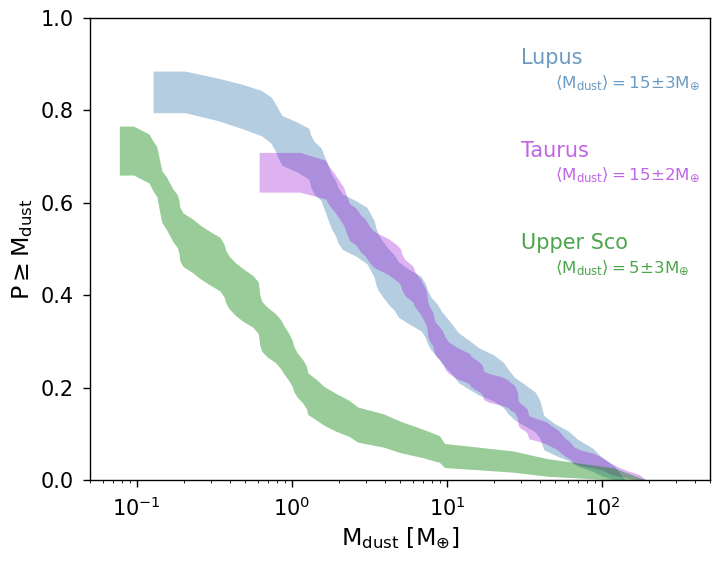

In [10]:
### PLOT KME
plt.close('all')
mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15)
mpl.rc('xtick.major', size=5, pad=7, width=1)
mpl.rc('ytick.major', size=5, pad=7, width=1)
mpl.rc('axes', linewidth=1)
mpl.rc('lines', markersize=5)    
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.set_xlim(0.05, 500)
ax.set_ylim(0.0, 1.0)
ax.set_ylabel(r'$\mathregular{P \geq M_{dust}}$', fontsize=17)
ax.set_xlabel(r'$\mathregular{M_{dust}}$' + ' ' + r'$\mathregular{[M_{\oplus}]}$', fontsize=17)
ax.fill_between(np.append(kme_lup['bin_end'][0], kme_lup['bin_ctr'][1:]),
               np.append(kme_lup['kme'][1], kme_lup['kme'][1:]) - np.append(kme_lup['err'][1], kme_lup['err'][1:]),
               np.append(kme_lup['kme'][1], kme_lup['kme'][1:]) + np.append(kme_lup['err'][1], kme_lup['err'][1:]),
               facecolor='steelblue', alpha=0.4, linewidth=0, edgecolor='steelblue')
ax.text(30, 0.90, 'Lupus', size=15, color='steelblue', alpha=0.8)
ax.text(50, 0.85, r'$\mathregular{ \langle M_{dust} \rangle =}$' + "{0:.0f}".format(float(mean_lup[0])) + r'$\mathregular{\pm}$' +
      "{0:.0f}".format(float(mean_lup[1])) + r'$\mathregular{M_{\oplus}}$', size=12, color='steelblue', alpha=0.8)
ax.fill_between(np.append(kme_tau['bin_end'][0], kme_tau['bin_ctr'][1:]),
               np.append(kme_tau['kme'][1], kme_tau['kme'][1:]) - np.append(kme_tau['err'][1], kme_tau['err'][1:]),
               np.append(kme_tau['kme'][1], kme_tau['kme'][1:]) + np.append(kme_tau['err'][1], kme_tau['err'][1:]),
               facecolor='darkviolet', alpha=0.3, linewidth=0, edgecolor='darkviolet')
ax.text(30,0.70, 'Taurus', size=15, color='darkviolet', alpha=0.6)
ax.text(50,0.65, r'$\mathregular{ \langle M_{dust} \rangle =}$' + "{0:.0f}".format(float(mean_tau[0])) + r'$\mathregular{\pm}$' +
      "{0:.0f}".format(float(mean_tau[1])) + r'$\mathregular{M_{\oplus}}$', size=12, color='darkviolet', alpha=0.6)
ax.fill_between(np.append(kme_usc['bin_end'][0], kme_usc['bin_ctr'][1:]),
               np.append(kme_usc['kme'][1], kme_usc['kme'][1:]) - np.append(kme_usc['err'][1], kme_usc['err'][1:]),
               np.append(kme_usc['kme'][1], kme_usc['kme'][1:]) + np.append(kme_usc['err'][1], kme_usc['err'][1:]),
               facecolor='green', alpha=0.4, linewidth=0, edgecolor='green')
ax.text(30, 0.50, 'Upper Sco', size=15, color='green', alpha=0.7)
ax.text(50, 0.45, r'$\mathregular{ \langle M_{dust} \rangle =}$' + "{0:.0f}".format(float(mean_usc[0])) + r'$\mathregular{\pm}$' +
      "{0:.0f}".format(float(mean_usc[1])) + r'$\mathregular{M_{\oplus}}$', size=12, color='green', alpha=0.7)
fig.savefig('../output/figure_08.png', bbox_inches='tight', dpi=100)

For LinMix version:

This provides an option to calculate the KME within Python using the LinMix package.

The output is slightly different than what is in the original paper, which used the ASURV package (outside Python) to calculate the KME (see above).

In [7]:
#### LOAD IN TABLES 
TL = Table.read('../output/data_lup.txt', format='ascii.ipac')
TT = Table.read('../output/data_tau.txt', format='ascii.ipac')
TU = Table.read('../output/data_usc.txt', format='ascii.ipac')

In [8]:
### GET KME 
x_lup, y_lup, yl_lup, yu_lup = calc_KME('lup', TL['MDust'], TL['Det'])
x_usc, y_usc, yl_usc, yu_usc = calc_KME('usc', TU['MDust'], TU['Det'])
x_tau, y_tau, yl_tau, yu_tau = calc_KME('tau', TT['MDust'], TT['Det'])


>>> lup
     median = 4.14 
     mean   = 14.03 

>>> usc
     median = 0.43 
     mean   = 3.34 

>>> tau
     median = 5.85 
     mean   = 14.99 


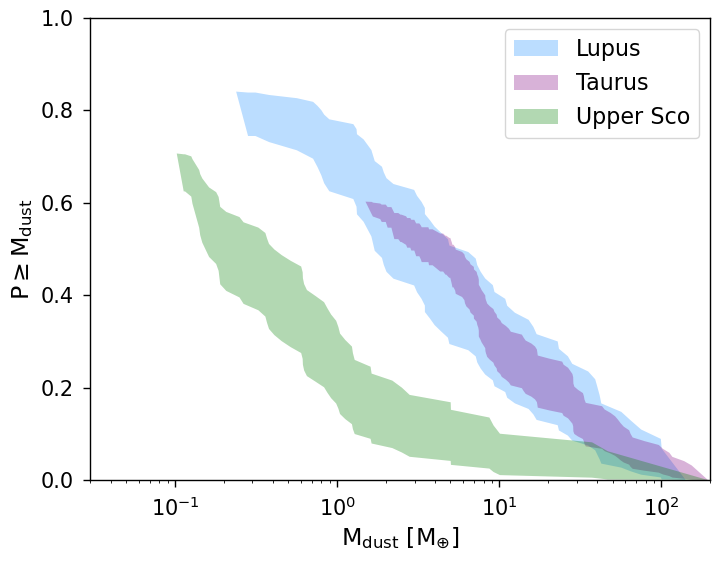

In [9]:
### PLOT KME DISTRIBUTIONS
plt.close('all')
mpl.rc('xtick',labelsize=15) 
mpl.rc('ytick',labelsize=15)
mpl.rc('xtick.major',size=5,pad=7,width=1)
mpl.rc('ytick.major',size=5,pad=7,width=1)
mpl.rc('axes',linewidth=1)
mpl.rc('lines',markersize=5)    
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.set_xlim(0.03,200)
ax.set_ylim(0.0,1.0)
ax.set_ylabel(r'$\mathregular{P \geq M_{dust}}$',fontsize=17)
ax.set_xlabel(r'$\mathregular{M_{dust}}$'+' '+r'$\mathregular{[M_{\oplus}]}$',fontsize=17)
ax.fill_between(x_lup,yl_lup,yu_lup,facecolor='dodgerblue',alpha=0.3,lw=0,label='Lupus')
ax.fill_between(x_tau,yl_tau,yu_tau,facecolor='purple',alpha=0.3,lw=0,label='Taurus')
ax.fill_between(x_usc,yl_usc,yu_usc,facecolor='green',alpha=0.3,lw=0,label='Upper Sco')
ax.legend(loc=1, prop={'size': 16})
fig.savefig('../output/figure_08_linmix.png',bbox_inches='tight',dpi=100)